Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): resting_bp, fasting_bs, rest_ecg, max_rate, exercise_induced_angina...
dbl (5): age, sex, chest_pain_type, chol, diagnosis_heart_disease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


resting_bp,max_rate,exercise_induced_angina
<dbl>,<dbl>,<fct>
-1.5606355,0.21141378,No
-0.6740773,1.24692927,No
-0.8957168,0.13470893,Yes
-1.1173564,1.70715837,No
-0.8957168,1.32363412,No
-1.3389959,2.20573990,No
-0.6740773,0.24976621,Yes
0.2124809,1.09351957,No
0.8773995,-0.05705319,Yes


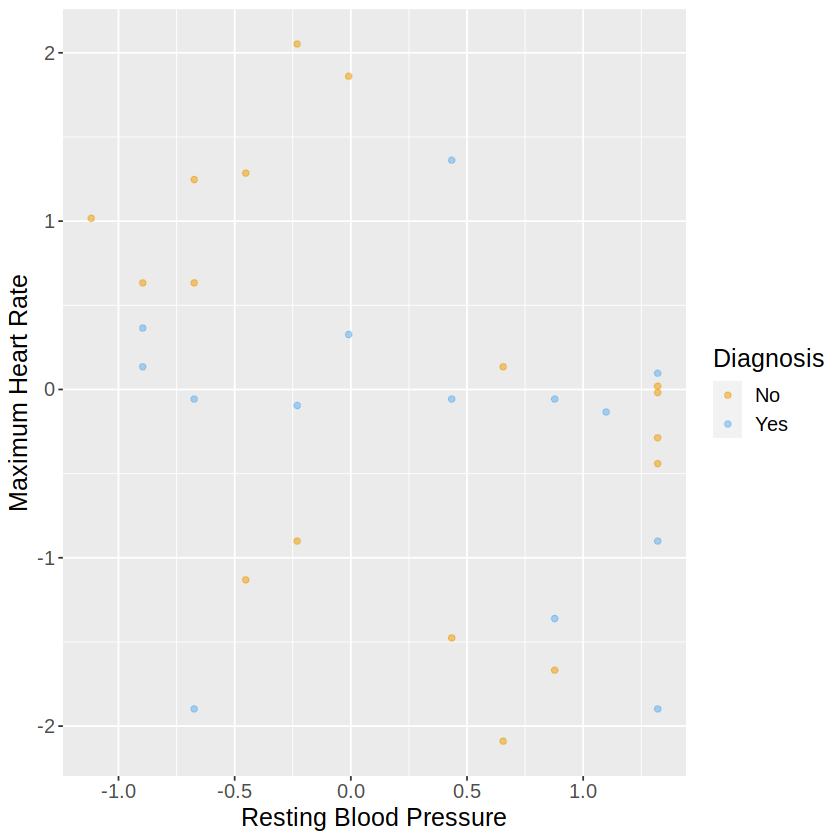

In [18]:
library(tidyverse)
library(tidymodels)


url<- "https://raw.githubusercontent.com/elaines6/dsci-100-group-project/main/processed.switzerland.data"
heart_raw_data <- read_csv(url, col_names = c("age", "sex", "chest_pain_type", "resting_bp", "chol", "fasting_bs", "rest_ecg", "max_rate",
                                             "exercise_induced_angina", "ST_depression", "slope_peak_exercise", "major_vessels", "thal", "diagnosis_heart_disease"))
heart_data_tidy <- heart_raw_data |>
    mutate(sex = as_factor(sex), chest_pain_type = as_factor(chest_pain_type), exercise_induced_angina = as_factor(exercise_induced_angina)) |>
    mutate(sex = fct_recode(sex, "Female" = "0", "Male" = "1")) |>
    mutate(exercise_induced_angina = fct_recode(exercise_induced_angina, "Yes" = "1", "No" = "0")) |>
    mutate(chest_pain_type = fct_recode(chest_pain_type, "Typical angina" = "1", "Atypical angina" = "2", "Non-anginal pain" = "3", "Asymptomatic" = "4")) |>
    select(age, sex, chest_pain_type, resting_bp, max_rate, exercise_induced_angina) %>% 
    filter(age != "?" & sex != "?"& chest_pain_type != "?"& resting_bp != "?"& max_rate!= "?"& exercise_induced_angina != "?")
    
unscaled_heart_data <- heart_data_tidy |>
    select(resting_bp, max_rate, exercise_induced_angina) |>
    mutate(resting_bp = as.integer(resting_bp), max_rate = as.integer(max_rate))

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |> 
    set_engine("kknn") |> 
    set_mode("classification") 

heart_data_recipe <- recipe(exercise_induced_angina ~ resting_bp + max_rate, data = unscaled_heart_data)

heart_data_recipe <- heart_data_recipe |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()


scaled_heart_data <- bake(heart_data_recipe, unscaled_heart_data)
scaled_heart_data



heart_data_split <- initial_split(scaled_heart_data, prop = 0.75, strata = exercise_induced_angina)
heart_data_train <- training(heart_data_split)
heart_data_test <- testing(heart_data_split) 

heart_plot<- heart_data_test|>
    ggplot(aes(x= resting_bp, y= max_rate, color = exercise_induced_angina))+ 
    geom_point(alpha= 0.5) +
    labs(x= "Resting Blood Pressure", 
         y= "Maximum Heart Rate",
         color = "Diagnosis") +
    scale_color_manual(values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 15))

heart_plot
